In [17]:
# import matplotlib.pyplot as plt
import numpy as np

In [18]:
cg_mean, cg_std = np.loadtxt('./results/beta_optimization').T
g_mean, g_std = np.loadtxt('./results/beta_optimization_gd.csv').T
betas = np.linspace(0, 2, 50)

In [19]:
plt.plot(betas, cg_mean, color='gray', label = 'Conjugate Gradient Descent')
plt.fill_between(betas, cg_mean - cg_std, cg_mean + cg_std, color='gray', alpha=0.2)
plt.plot(betas, g_mean, color='red', label = 'Gradient Descent')
plt.fill_between(betas, g_mean - g_std, g_mean + g_std, color='red', alpha=0.2)
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.legend()
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

NameError: name 'plt' is not defined

In [ ]:
betas

array([0.        , 0.04081633, 0.08163265, 0.12244898, 0.16326531,
       0.20408163, 0.24489796, 0.28571429, 0.32653061, 0.36734694,
       0.40816327, 0.44897959, 0.48979592, 0.53061224, 0.57142857,
       0.6122449 , 0.65306122, 0.69387755, 0.73469388, 0.7755102 ,
       0.81632653, 0.85714286, 0.89795918, 0.93877551, 0.97959184,
       1.02040816, 1.06122449, 1.10204082, 1.14285714, 1.18367347,
       1.2244898 , 1.26530612, 1.30612245, 1.34693878, 1.3877551 ,
       1.42857143, 1.46938776, 1.51020408, 1.55102041, 1.59183673,
       1.63265306, 1.67346939, 1.71428571, 1.75510204, 1.79591837,
       1.83673469, 1.87755102, 1.91836735, 1.95918367, 2.        ])

In [ ]:
a = np.random.uniform(0, 1, size=(196, 0))

In [ ]:
import nilearn
import numpy as np
from nilearn import datasets, plotting
from sklearn.feature_selection import SelectPercentile, f_classif

In [ ]:
aal = datasets.fetch_atlas_aal()


In [ ]:
len(aal.labels)

116

### Loading connectivity matrices 

In [ ]:
ising_rep = np.load(
    '../data/gd_all.npy'
)
ising_rep.shape
data = np.mean(ising_rep, axis = 0)
data.shape
diag = np.load('../data/diag_all.npy')
fs = SelectPercentile(f_classif, percentile=10)
ising_rep = fs.fit_transform(ising_rep, diag)
print(ising_rep.shape)

(841, 1346)


In [ ]:
score_mat = fs.scores_.reshape(116, -1)

In [ ]:
coordinates = plotting.find_parcellation_cut_coords(aal['maps'])

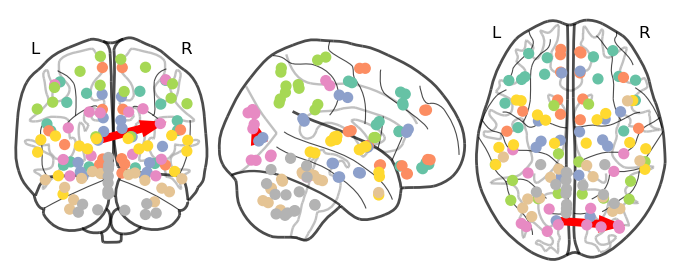

In [ ]:
plotting.plot_connectome(score_mat, coordinates,
                         edge_threshold=17)

In [11]:
def top_pairs(scores, coordinates, n_rois = 116, k = 5):
    idx = np.argsort(scores)[-k:]
    rois = set() 
    rois_scores = {}
    for i in idx:
        rois.add(i//n_rois)
        rois.add(i%n_rois)
        rois_scores[i//n_rois] = scores[i]
        rois_scores[i%n_rois] = scores[i]
    rois = list(rois)
    coordinates = coordinates[rois]
    scores = scores.reshape(n_rois, n_rois)[rois][:, rois]
    return coordinates, scores, rois_scores

In [ ]:
np.sort(score_mat.flatten())[-5:]

array([15.30870303, 15.50335759, 15.68096846, 15.84759285, 15.86626992,
       16.01626256, 16.20886887, 16.29487998, 16.39882224, 17.94176412])

In [ ]:
a = [1, 2, 3, 4]
score_mat[a][:, a].shape


(4, 4)

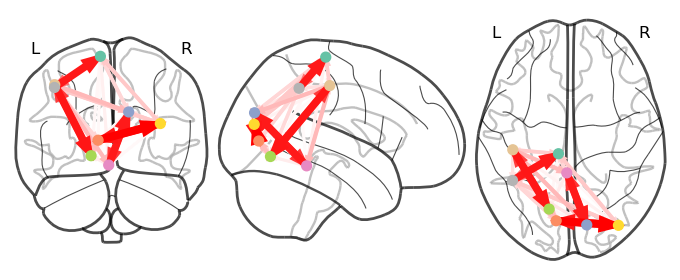

In [13]:
coords, scores, rois = top_pairs(score_mat.flatten(), coordinates, k=5)
plotting.plot_connectome(scores, coords)

In [14]:
labels = [(aal.labels[i], rois[i]) for i in rois]
labels

[('Vermis_3', 16.01626255510945),
 ('Cuneus_R', 16.01626255510945),
 ('Parietal_Inf_L', 16.208868866706624),
 ('Paracentral_Lobule_L', 16.208868866706624),
 ('Postcentral_L', 16.294879978747908),
 ('Lingual_L', 16.294879978747908),
 ('Occipital_Mid_R', 17.941764124924827),
 ('Calcarine_L', 17.941764124924827)]

In [16]:
sorted(labels, key=lambda x: x[1], reverse=True)

[('Occipital_Mid_R', 17.941764124924827),
 ('Calcarine_L', 17.941764124924827),
 ('Postcentral_L', 16.294879978747908),
 ('Lingual_L', 16.294879978747908),
 ('Parietal_Inf_L', 16.208868866706624),
 ('Paracentral_Lobule_L', 16.208868866706624),
 ('Vermis_3', 16.01626255510945),
 ('Cuneus_R', 16.01626255510945)]